网格搜索 Continuous BTSP: 不同 threshold × memory size 下的平均归一化海明距离 (mask_ratio=0.3)...



Memory sizes:   9%|▉         | 1/11 [01:51<18:38, 111.84s/it]

Memory size = 1000: 最佳 Threshold = 4, 平均归一化海明距离 = 0.0018


Memory sizes:  18%|█▊        | 2/11 [04:12<19:21, 129.07s/it]

Memory size = 2000: 最佳 Threshold = 5, 平均归一化海明距离 = 0.0057


Memory sizes:  27%|██▋       | 3/11 [07:40<22:00, 165.09s/it]

Memory size = 3000: 最佳 Threshold = 5, 平均归一化海明距离 = 0.0088


Memory sizes:  36%|███▋      | 4/11 [11:34<22:23, 191.99s/it]

Memory size = 4000: 最佳 Threshold = 6, 平均归一化海明距离 = 0.0232


Memory sizes:  45%|████▌     | 5/11 [16:14<22:23, 223.87s/it]

Memory size = 5000: 最佳 Threshold = 6, 平均归一化海明距离 = 0.0268


Memory sizes:  55%|█████▍    | 6/11 [21:26<21:08, 253.70s/it]

Memory size = 6000: 最佳 Threshold = 6, 平均归一化海明距离 = 0.0370


Memory sizes:  64%|██████▎   | 7/11 [27:24<19:11, 287.76s/it]

Memory size = 7000: 最佳 Threshold = 6, 平均归一化海明距离 = 0.0618


Memory sizes:  73%|███████▎  | 8/11 [43:05<24:47, 495.76s/it]

Memory size = 8000: 最佳 Threshold = 7, 平均归一化海明距离 = 0.0719


Memory sizes:  82%|████████▏ | 9/11 [1:02:27<23:28, 704.03s/it]

Memory size = 9000: 最佳 Threshold = 7, 平均归一化海明距离 = 0.0833


Memory sizes:  91%|█████████ | 10/11 [1:23:20<14:33, 873.50s/it]

Memory size = 10000: 最佳 Threshold = 7, 平均归一化海明距离 = 0.1062


Memory sizes: 100%|██████████| 11/11 [1:48:51<00:00, 593.82s/it] 


Memory size = 11000: 最佳 Threshold = 7, 平均归一化海明距离 = 0.1468


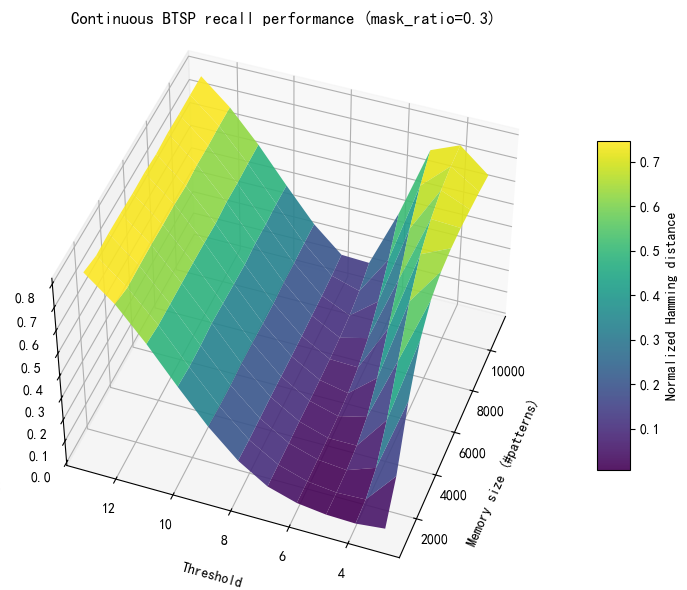

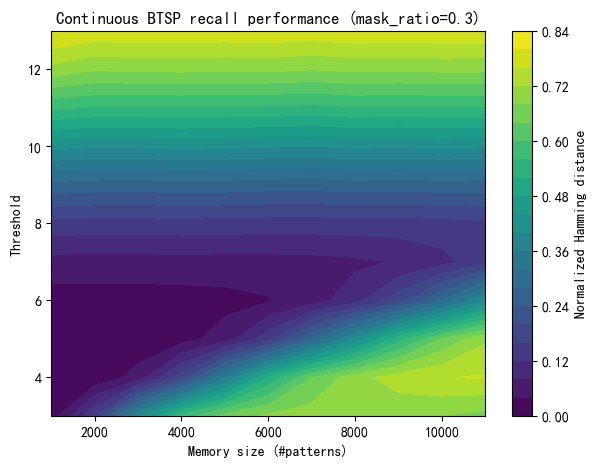


最优参数组合：Memory size = 1000, Threshold = 4, 平均归一化海明距离 = 0.0018


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from continuousBTSP import continuousBTSPNetwork
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ---------------- 参数设置 ----------------
n_input = 10000
n_memory = 15000
fq = 0.0025
fp = 0.005
fw = 0.6
batch_size = 256
n_repeats = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# 扫描参数
mask_ratio = 0.3
memory_sizes = np.arange(1000, 12000, 1000)      # 记忆规模
threshold_values = np.arange(3, 14, 1)           # 阈值扫描范围

# 结果矩阵
results = np.zeros((len(memory_sizes), len(threshold_values)))

print(f"网格搜索 Continuous BTSP: 不同 threshold × memory size 下的平均归一化海明距离 (mask_ratio={mask_ratio})...\n")


for i, n_pat in enumerate(tqdm(memory_sizes, desc="Memory sizes")):
    patterns = None
    for j, th in enumerate(threshold_values):

        
        net = continuousBTSPNetwork(
            n_input=n_input,
            n_memory=n_memory,
            fq=fq,
            fp=fp,
            fw=fw,
            threshold=th,
            device=device
        )

   
        if patterns is None:
            patterns = net.make_sparse_patterns(n_pat)

     
        net.train_patterns(patterns, batch_size=batch_size)

        #  掩码评估
        mean_rel_diss = net.compute_relative_dissimilarity_vectorized_fast(
            patterns=patterns,
            mask_ratios=[mask_ratio],
            n_repeats=n_repeats,
            batch_size=batch_size,
        )[0]

        results[i, j] = mean_rel_diss

    #  输出每个记忆规模下的最佳阈值 
    best_idx = np.argmin(results[i, :])
    best_th = threshold_values[best_idx]
    best_val = results[i, best_idx]
    print(f"Memory size = {n_pat}: 最佳 Threshold = {best_th}, 平均归一化海明距离 = {best_val:.4f}")


X, Y = np.meshgrid(memory_sizes, threshold_values, indexing='ij')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, results, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel("Memory size (#patterns)", labelpad=10)
ax.set_ylabel("Threshold", labelpad=10)
ax.set_zlabel("Normalized Hamming distance", labelpad=10)
ax.set_title(f"Continuous BTSP recall performance (mask_ratio={mask_ratio})")
fig.colorbar(surf, shrink=0.6, aspect=10, label="Normalized Hamming distance")
ax.view_init(elev=45, azim=200)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 5))
cs = plt.contourf(memory_sizes, threshold_values, results.T, levels=20, cmap='viridis')
plt.xlabel("Memory size (#patterns)")
plt.ylabel("Threshold")
plt.title(f"Continuous BTSP recall performance (mask_ratio={mask_ratio})")
plt.colorbar(cs, label="Normalized Hamming distance")
plt.show()


best_idx = np.unravel_index(np.argmin(results), results.shape)
best_mem = memory_sizes[best_idx[0]]
best_th = threshold_values[best_idx[1]]
best_val = results[best_idx]

print(f"\n最优参数组合：Memory size = {best_mem}, Threshold = {best_th}, 平均归一化海明距离 = {best_val:.4f}")
